In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
import itertools

#### Figure aesthetics

In [2]:
#print(plt.style.available)
plt.style.use('seaborn-poster')
plt.style.use('seaborn-whitegrid')

#### Downlad data

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
    
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
get_data()

#### Prepare dataset

In [106]:
## prepare dataset
confirmed = pd.read_csv("confirmed.csv")
deaths = pd.read_csv("deaths.csv")
recovered = pd.read_csv("recovered.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    #data=data.transpose().reset_index().rename(columns={'index':'Date'})
    #data['Date'] = pd.to_datetime(data['Date'])
    
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

In [107]:
inactive=deaths.add(recovered)
data=confirmed.subtract(inactive)
data=data.transpose().reset_index().rename(columns={'index':'Date'})
data['Date'] = pd.to_datetime(data['Date'])

#### List of countries in dataset

In [123]:
population_df=pd.read_csv("countries_population.csv",  encoding = "ISO-8859-1", header=None, usecols=[1,2], names=["country_name", "population"])
population_df

population_df['population'] = population_df['population'].apply(lambda x: str(x).replace(",", ""))
population_df['population'] = pd.to_numeric(population_df['population'], errors="coerce")

In [158]:
dictionary_country_names={
"US":"United States",
"Congo (Kinshasa)":"Congo",
"Cote d'Ivoire":"Ivory Coast",
"Czechia":"Czech Republic",
"French Guiana":"Guyana",
"Korea, South":"South Korea",
}

countries_populations = {}

for data_country_name in data.columns[1:]:
    searchfor=[data_country_name]
    try:
        searchfor.append(dictionary_country_names[data_country_name])
    except:
        pass
    
    check_names=0
    if check_names==1:
        if len(population_df[population_df["country_name"].str.contains('|'.join(searchfor))]) != 1:
            print(" ")   
            print(data_country_name)
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))] )
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum() )
            print(" ")
    countries_populations[data_country_name]=population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum()

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### Choose countries to plot (separate by ";" )

In [190]:
#countries_to_plot="Germany;France;Poland;Italy;Korea, South;China".split(";")
countries_to_plot="Germany;France;Poland".split(";")

#### Make plot

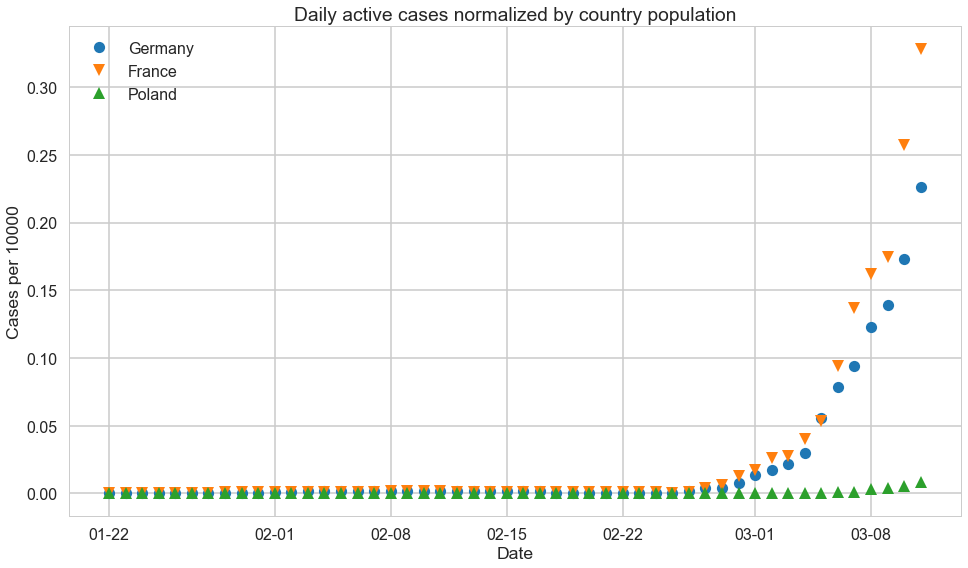

In [196]:
##extract data for each country
dates=data["Date"].values
countries=[]
per_num=10000
for country in countries_to_plot:
    countries.append((data[country].values/countries_populations[country])*per_num)

## Create figure and plot space
fig, ax = plt.subplots(figsize=(16, 9))
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
## Add x-axis and y-axis
for country, country_name in zip(countries, countries_to_plot):
    ax.plot(dates, country, marker=next(marker), linestyle='', label=country_name)
## Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Cases per "+str(per_num),
       title="Daily active cases normalized by country population")
## Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

## axes limits
#ax.set_xlim([datetime.date(2020, 2, 10), datetime.date.today() + datetime.timedelta(days=3)])# datetime.date(2020, 3, 15)])
#ax.set_ylim([0,0.05])
ax.legend()
plt.show()